In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Model Evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score

# Image Data Generator
from keras.preprocessing.image import ImageDataGenerator

# Kaggle dataset
from kaggle_datasets import KaggleDatasets

# Pre-trained
from tensorflow.keras.applications import DenseNet201, Xception

# Keras components
from keras.models import Model, Sequential
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers import Input, Reshape, Concatenate, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout, GlobalMaxPooling2D, GlobalAvgPool2D
from keras.layers import Subtract, Multiply
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import to_categorical

# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# # Experiment tracking using Weights and Biases
# import wandb
# from wandb.keras import WandbCallback

# for error
# https://stackoverflow.com/questions/12984426/python-pil-ioerror-image-file-truncated-with-big-images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# TPU setting
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Configuration
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
print(BATCH_SIZE)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8
64


### Pipeline: Training All Training Samples

In [3]:
# Get Images path and labels

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path("product-matching-id-ndsc-2020")

def get_images_path_and_labels(df, path, get_label=True):
    image1_paths = []
    image2_paths = []
    labels = []

    image1_paths = df.image_1.apply(lambda x: '{}/{}/{}/{}'.format(GCS_DS_PATH, path, path, x)).tolist()
    image2_paths = df.image_2.apply(lambda x: '{}/{}/{}/{}'.format(GCS_DS_PATH, path, path, x)).tolist()
    
    if get_label:
        labels = df.Label.tolist()
        return image1_paths, image2_paths, labels
    else:
        return image1_paths, image2_paths, [0] * len(image1_paths)

In [4]:
# Functions to calculate metrics
from keras import backend as K

def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def exponent_neg_manhattan_distance(vests):
    ''' Helper function for the similarity estimate of the two vectors'''
    x, y = vests
    return K.exp(-K.sum(K.abs(x - y), axis=1, keepdims=True))

def manhattan_distance(vests):
    ''' Helper function for the similarity estimate of the two vectors'''
    x, y = vests
    return K.sum(K.abs(x - y), axis=1, keepdims=True)

def dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Define Model

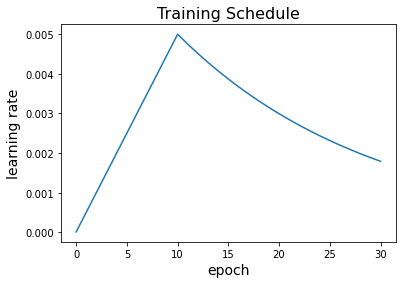

[1e-05, 0.0005090000000000001, 0.0010080000000000002, 0.0015070000000000003, 0.0020060000000000004, 0.0025050000000000007, 0.0030040000000000006, 0.0035030000000000005, 0.004002, 0.004501000000000001, 0.005, 0.00475, 0.0045125, 0.004286875, 0.00407253125, 0.003868904687499999, 0.003675459453124999, 0.003491686480468749, 0.0033171021564453113, 0.0031512470486230455, 0.0029936846961918936, 0.0028440004613822984, 0.0027018004383131834, 0.002566710416397524, 0.0024383748955776477, 0.002316456150798765, 0.0022006333432588268, 0.0020906016760958855, 0.001986071592291091, 0.0018867680126765363, 0.0017924296120427094]


In [5]:
# Model Parameter
# Configuration
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_CHANNELS = 3
DIM = 299
IMAGE_SIZE = (DIM, DIM)
EMBEDDING_SIZE = 128
COEF_SMOOTHING = 0.1
COEF_DROPOUT = 0.01
NUM_FOLDS = 4

# CUSTOM LEARNING SCHEUDLE
# # Xception
# EPOCH = 15
# SUSTAIN_EPOCHS = 1
# LR_START = 1e-5
# LR_MAX = 1e-3
# LR_RAMPUP_EPOCHS = 8
# LR_SUSTAIN_EPOCHS = 0
# LR_STEP_DECAY = 0.8

# DenseNet201
EPOCH = 30
SUSTAIN_EPOCHS = 1
LR_START = 1e-5
LR_MAX = 5e-3
LR_RAMPUP_EPOCHS = 10
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.95

# Define model and Scheduler Learning Rate
def get_model():
    with strategy.scope():
        input_shape = (2, DIM, DIM, IMAGE_CHANNELS)
        first_input = Input(input_shape)

        # slice the tensor of 2 images
        input_1 = Lambda( lambda x: tf.reshape(tf.slice( x, [0,0,0,0,0], [-1, 1, DIM, DIM, IMAGE_CHANNELS]), shape=(-1, DIM, DIM, IMAGE_CHANNELS)) )(first_input)
        input_2 = Lambda( lambda x: tf.reshape(tf.slice( x, [0,1,0,0,0], [-1, 1, DIM, DIM, IMAGE_CHANNELS]), shape=(-1, DIM, DIM, IMAGE_CHANNELS)) )(first_input)
        
        # MAKE SURE THE BASE MODEL CORRECT
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(DIM, DIM, IMAGE_CHANNELS))

        x1 = base_model(input_1)
        x2 = base_model(input_2)

#         x1 = Concatenate(axis=-1)([GlobalMaxPooling2D()(x1), GlobalAvgPool2D()(x1)]) # concatenating max pool and avg pool
#         x2 = Concatenate(axis=-1)([GlobalMaxPooling2D()(x2), GlobalAvgPool2D()(x2)])

        x1_max = GlobalMaxPooling2D()(x1) # pooling max
        x2_max = GlobalMaxPooling2D()(x2)

        x1_avg = GlobalAvgPool2D()(x1) # pooling avg
        x2_avg = GlobalAvgPool2D()(x2)
        
        x3_max = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1_max, x2_max]) # calculate cosine distance between input1 and input2
        x4_max = Lambda(exponent_neg_manhattan_distance, output_shape=dist_output_shape)([x1_max, x2_max]) # calculate exp negative manhattan distance between input1 and input2
        x5_max = Lambda(manhattan_distance, output_shape=dist_output_shape)([x1_max, x2_max]) # calculate manhattan distance between input1 and input2

        x3_avg = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1_avg, x2_avg])
        x4_avg = Lambda(exponent_neg_manhattan_distance, output_shape=dist_output_shape)([x1_avg, x2_avg])
        x5_avg = Lambda(manhattan_distance, output_shape=dist_output_shape)([x1_avg, x2_avg])

#         x3 = Lambda(cosine_distance, output_shape=cos_dist_output_shape)([x1, x2])
#         x4 = Lambda(exponent_neg_manhattan_distance, output_shape=dist_output_shape)([x1, x2])
#         x5 = Lambda(manhattan_distance, output_shape=dist_output_shape)([x1, x2])

        x = Concatenate(axis=-1)([x3_max, x4_max, x5_max, x3_avg, x4_avg, x5_avg])
    
#         x = Dense(EMBEDDING_SIZE, activation='relu')(x)
#         x = Dropout(COEF_DROPOUT)(x)
        
        out = Dense(1, activation='sigmoid')(x)

        model = Model(first_input, out)
        model.compile(loss= tf.keras.losses.BinaryCrossentropy(label_smoothing = COEF_SMOOTHING), 
                      metrics=['acc', f1_m], optimizer= Adam(learning_rate = LR_START))
#         model.summary()
    return model

def learning_rate_function(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//SUSTAIN_EPOCHS)
    return lr
    
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose = True)

# Plotting learning rate curve
rng = [i for i in range(EPOCH+1)]
y = [learning_rate_function(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()
print(y)

### Preprocess Image
Use TensorFlow Dataset for faster training time (use feature `prefetch()` and `cache()`)

In [6]:
# Preprocess Image
# Data Generator using GPU
def decode_image(filename1, filename2, label=None, image_size=(DIM, DIM)):
    bits1 = tf.io.read_file(filename1)
    image1 = tf.image.decode_jpeg(bits1, channels=3, try_recover_truncated=True)
    image1 = tf.cast(image1, tf.float32) / 255.0
    image1 = tf.image.resize(image1, image_size)

    bits2 = tf.io.read_file(filename2)
    image2 = tf.image.decode_jpeg(bits2, channels=3, try_recover_truncated=True)
    image2 = tf.cast(image2, tf.float32) / 255.0
    image2 = tf.image.resize(image2, image_size)
        
    if label is None:
        return [image1, image2]
    else:
        return [image1, image2], label

def get_training_dataset(df):
    image1, image2, label = get_images_path_and_labels(df, 'training_img', get_label=True)
    dataset = ( tf.data.Dataset.from_tensor_slices((image1, image2, label))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .cache()
                 .repeat()
                 .shuffle(2048)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO)
              )
    return dataset

def get_validation_dataset(df):
    image1, image2, label = get_images_path_and_labels(df, 'training_img', get_label=True)
    dataset = ( tf.data.Dataset.from_tensor_slices((image1, image2, label))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .cache()
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO)
              )
    return dataset

### Training Model

In [7]:
def train_model(model, df, learning_rate_scheduler):
    
    # copy the training set
    train = df.copy()
    
#     # apply label smoothing
#     # Perform label smoothing; change label 1 to 0.9, and label 0 to 0.1
#     train.iloc[:,-1] = train.iloc[:,-1].apply(lambda x: (1-COEF_SMOOTHING) if x == 1 else (COEF_SMOOTHING))
    
#     # get samples in training data that have the same image and labelled 1 -> assign label to 1
#     # the idea is to make sure the model confident with these samples are similar
#     identic_img_idx = train.loc[(train.image_1 == train.image_2) & (train.Label == 0.9)].index
#     train.loc[identic_img_idx, 'Label'] = 1
#     # get samples in training data that have the same title and labelled 1 -> assign label to 1
#     identic_txt_idx = train.loc[(train.title_1 == train.title_2) & (train.Label == 0.9)].index
#     train.loc[identic_txt_idx, 'Label'] = 1
    
#     print("Identic Image with Label 1 :", len(identic_img_idx))
#     print("Identic Title with Label 1 :", len(identic_txt_idx))
    print("Training data shape :", train.shape)
    
    # Get TF Dataset
    train_dataset = get_training_dataset(train)
    
    model = get_model()
    history = model.fit(train_dataset, steps_per_epoch = len(train.Label) // BATCH_SIZE,
                        callbacks = [learning_rate_scheduler],
                        epochs = EPOCH
                       )
            
    return model, history

In [8]:
# # Perform Training Model

# # Define model
# model = get_model()

# # Define learning rate scheduler
# learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose = True)

# # Get traning data
# GCS_DS_PATH = KaggleDatasets().get_gcs_path("pre-product-matching-id-ndsc-2020")
# train = pd.read_csv("../input/pre-product-matching-id-ndsc-2020/new_training_set.csv").iloc[:, 1:]

# # Perform training
# model, history = train_model(model, train, learning_rate_scheduler)

In [9]:
# # Print Model Summary
# model.summary()

# # Save model
# model_name = "Xception" + "_" + str(BATCH_SIZE) + "_" + str(EMBEDDING_SIZE) + "_" + str(EPOCH) + "_" + str(LR_START) + "_" + 'BinaryCrossEntropy' + ".h5"
# print(model_name)
# model.save(model_name)

In [10]:
# # Plot History
# history_df = pd.DataFrame(history.history)

# # Plot loss, accuracy, and f1 score
# history_df['loss'].plot()
# history_df['acc'].plot()
# history_df['f1_m'].plot()

### Read Model and Optimize Cut-off Prediction

In [11]:
# From Kaggle Dataset, get model and y_probas
import joblib
from sklearn.metrics import roc_curve, auc, f1_score

# get probabilities from Cross Validation

# Xception 400
# probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_xception400.pkl")

# # DenseNet201 128, Manual Label Smoothing
# probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_densenet128.pkl")

# # DenseNet201 128, Non Manual Label Smoothing
# probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_densenet128_nonmanuallabeling.pkl")

In [12]:
# Optimize cut off / threshold
def get_best_threshold(fpr, tpr, thresholds):
    # threshold based on min absolute difference of sen and spec
    diff = np.abs(tpr - (1-fpr))
    idx = np.where(diff == min(diff))[0][0]
    cut_min = thresholds[idx]
    
    # threshold based on youden index    
    diff = tpr + (1-fpr) - 1
    idx = np.where (diff == max(diff))[0][0]
    cut_youden = thresholds[idx]
    
    # threshold based on highest average of sensitivity and specisficity
    diff = (tpr + (1-fpr)) / 2
    idx = np.where (diff == max(diff))[0][0]
    cut_avg = thresholds[idx]
    
    # threshold based on min euclidian distance in ROC curve
    diff = np.sqrt(fpr**2 + (1-tpr)**2)
    idx = np.where (diff == min(diff))[0][0]
    cut_euclid = thresholds[idx]
    
    return cut_min, cut_youden, cut_avg, cut_euclid

def get_avg_best_threshold(y_vals, y_probas):
    mins = []
    youdens = []
    avgs = []
    euclids = []
    
    for i in range(len(y_vals)):
        fpr, tpr, thresholds = roc_curve(y_vals[i], y_probas[i])
        cut_min, cut_youden, cut_avg, cut_euclid = get_best_threshold(fpr, tpr, thresholds)
        mins.append(cut_min)
        youdens.append(cut_youden)
        avgs.append(cut_avg)
        euclids.append(cut_euclid)
        print("Fold ", i)
        print("Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance")
        print(cut_min, cut_youden, cut_avg, cut_euclid)
    
    print("Average all folds")
    print("Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance")
    print(np.mean(mins), np.mean(youdens), np.mean(avgs), np.mean(euclids))
    cut_min, cut_youden, cut_avg, cut_euclid = np.mean(mins), np.mean(youdens), np.mean(avgs), np.mean(euclids)
    averaged_threshold = np.mean([cut_min, cut_youden, cut_avg, cut_euclid])
    print("FINAL THRESHOLD ", averaged_threshold)
    return averaged_threshold

def evaluate_thresholds(y_vals, y_probas, best_threshold):
    f1s = []
    for i in range(len(y_vals)):
        fpr, tpr, thresholds = roc_curve(y_vals[i], y_probas[i])
        auc_score = auc(fpr, tpr)
        y_pred = np.where(y_probas[i] >= best_threshold, 1, 0)
        f1 = f1_score(y_vals[i], y_pred)
        f1s.append(f1)
        print("Fold ", i)
        print("ROC AUC | F1 ")
        print(auc_score, f1)
    print("F1 mean :", np.mean(f1s), ", std: ", np.std(f1s))

In [13]:
# # Evaluate and get best threshold

# # Xception 400
# probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_xception400.pkl")

# y_probas = probas_vals[0]
# y_vals = probas_vals[1]

# best_threshold = get_avg_best_threshold(y_vals, y_probas)
# evaluate_thresholds(y_vals, y_probas, best_threshold)

In [14]:
# # Evaluate and get best threshold
# # DenseNet201 128, Manual Label Smoothing
# probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_densenet128.pkl")

# y_probas = probas_vals[0]
# y_vals = probas_vals[1]

# best_threshold = get_avg_best_threshold(y_vals, y_probas)
# evaluate_thresholds(y_vals, y_probas, best_threshold)

In [15]:
# # Evaluate and get best threshold

# # # DenseNet201 128, Non Manual Label Smoothing
# probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_densenet128_nonmanuallabeling.pkl")

# y_probas = probas_vals[0]
# y_vals = probas_vals[1]

# best_threshold = get_avg_best_threshold(y_vals, y_probas)
# evaluate_thresholds(y_vals, y_probas, best_threshold)

In [16]:
# Evaluate and get best threshold

# # DenseNet201 128, Non Manual Label Smoothing + Distance embedding
probas_vals = joblib.load("../input/shopeeproductmatching/probas_vals_densenet_distance.pkl")

y_probas = probas_vals[0]
y_vals = probas_vals[1]

best_threshold = get_avg_best_threshold(y_vals, y_probas)
evaluate_thresholds(y_vals, y_probas, best_threshold)

Fold  0
Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance
0.16996369 0.30516595 0.30516595 0.28864905
Fold  1
Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance
0.64035034 0.78223264 0.78223264 0.6937445
Fold  2
Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance
0.56644654 0.6728268 0.6728268 0.5633914
Fold  3
Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance
0.57972807 0.5965923 0.5965923 0.5965923
Average all folds
Min Abs Diff | Youden Idx | Highest Avg | Euclid Distance
0.48912215 0.58920443 0.58920443 0.53559434
FINAL THRESHOLD  0.55078137
Fold  0
ROC AUC | F1 
0.9297384847825333 0.844715757344525
Fold  1
ROC AUC | F1 
0.916684977938075 0.8554012868269556
Fold  2
ROC AUC | F1 
0.935221035988594 0.8812737971616476
Fold  3
ROC AUC | F1 
0.9398900944861606 0.8860585197934596
F1 mean : 0.866862340281647 , std:  0.017306142546332847


### Get The Model from previous Training

In [17]:
from keras.models import load_model

# # DenseNet201 128, Non Manual Label Smoothing

configs = {'DIM': DIM, 'f1_m': f1_m}
model_path = "../input/shopeeproductmatching/DenseNet201_Distance_Cosine_Manhattan_NegExpManhattan_64_128_30_1e-05_BinaryCrossEntropy.h5"

model = load_model(model_path, configs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2, 299, 299, 0                                            
__________________________________________________________________________________________________
lambda_8 (Lambda)               (None, 299, 299, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 299, 299, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
densenet201 (Model)             (None, 9, 9, 1920)   18321984    lambda_8[0][0]                   
                                                                 lambda_9[0][0]             

### Prediction Pipeline

In [18]:
### Prepare Test Set

# path
GCS_DS_PATH = KaggleDatasets().get_gcs_path("product-matching-id-ndsc-2020")
SUBFOLDER = 'test_img'

# read test file
test = pd.read_csv("../input/product-matching-id-ndsc-2020/new_test_set.csv").iloc[:,1:]

# perform
test_safe = test.iloc[0:19008,:]

# get image paths
test_im1, test_im2, dummy_label = get_images_path_and_labels(test_safe, SUBFOLDER, get_label=False)

# Create TF Dataset for test set
test_dataset = (tf.data.Dataset.from_tensor_slices((test_im1, test_im2, dummy_label))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .batch(BATCH_SIZE)
               )

In [19]:
# Perform Prediction
print("Perform Scoring")
y_proba1 = model.predict(test_dataset, verbose=1)

print("Complete Scoring")
print(y_proba1.shape)

Perform Scoring
297/297 [==============================] - 1317s 4s/step
Complete Scoring
(19008, 1)


In [20]:
# Perform cut-off

y_pred = np.where(y_proba1 >= best_threshold, 1, 0)

print("prediction shape :", y_pred.shape)
print("prediction proportion :", y_pred.mean())

prediction shape : (19008, 1)
prediction proportion : 0.493108164983165


In [21]:
# create test dataframe
test['pair_index'] = test.index
test['label'] = 1
test.iloc[0:19008,-1] = y_pred
test[['pair_index', 'label']].to_csv("submission1.csv", index=False)
test.head()

,title_1,image_1,title_2,image_2,pair_index,label
0,Celana Chino Panjang Original Motz,6985a78ebd6b7d9f120f852b412bba5b.jpg,Celana Chino Panjang Original Motz,81f8fab965d009483d004af0c697dd97.jpg,0,0
1,[BISA COD] Tas LOL Boneka Flash Anak Ransel,4d6f929847cbe632b15baa556646a414.jpg,Bisa Cod Tas Lol Boneka Mewah Anak Ransel Tas ...,1e2facde94db9de3037741ec4a5313c8.jpg,1,1
2,KOYO AJAIB KINOKI GOLD paket Standard,e21056441f03442737a2c074a4ab232d.jpg,BL - V.PJG Baju Kaos Vneck Polos Lengan Panjan...,7b91ab6c71c6e9ed432201f12379509c.jpg,2,0
3,Zwitsal Natural Aloe Vera Baby Bath 2 In 1 Hai...,3ac880adf8ffbcf23846554efc052694.jpg,ZWITSAL Natural Baby Bath 2 in 1 Hair & Body b...,46b00a7c6a869e00cad8cc08fb56a2f7.jpg,3,1
4,TAS IMPORT JAKARTA CLASSIC DIAMOND JELLY MATTE...,4ddd79c9d601bd25c1a56e0a10fb5708.jpg,TAS IMPORT JAKARTA CLASSIC DIAMOND JELLY MATTE...,10a97ae389e298f72bc455aa4cb4fba7.jpg,4,0


In [22]:
# perform
test_safe2 = test.iloc[19070:,:]

# get image paths
test_im1, test_im2, dummy_label = get_images_path_and_labels(test_safe2, SUBFOLDER, get_label=False)

# Create TF Dataset for test set
test_dataset = (tf.data.Dataset.from_tensor_slices((test_im1, test_im2, dummy_label))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .batch(BATCH_SIZE)
               )

In [23]:
# Perform Prediction
print("Perform Scoring")
y_proba2 = model.predict(test_dataset, verbose=1)

print("Complete Scoring")
print(y_proba2.shape)

Perform Scoring
212/212 [==============================] - 920s 4s/step
Complete Scoring
(13510, 1)


In [24]:
# Perform cut-off

y_pred = np.where(y_proba2 >= best_threshold, 1, 0)

print("prediction shape :", y_pred.shape)
print("prediction proportion :", y_pred.mean())

prediction shape : (13510, 1)
prediction proportion : 0.49844559585492226


In [25]:
# Save the result for submission

# # create test dataframe
# test['label'] = y_pred
# test['pair_index'] = test.index
# test.head()

test.iloc[19070:,-1] = y_pred

# save as csv
test[['pair_index', 'label']].to_csv("submission2.csv", index=False)
print("Positive proportion :", test.label.mean())
print("File submission save")

Positive proportion : 0.4962860650705955
File submission save
